In [29]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /Users/dmitt/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dmitt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
# Load the dataset
df = pd.read_csv('data/movie.csv')  # Adjust filename/path
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [31]:
df.shape

(40000, 2)

In [32]:
df[df.duplicated()]

,text,label
2164,"I find it rather useless to comment on this ""m...",0
3236,An absolutely atrocious adaptation of the wond...,0
3428,When I first saw this film it was not an impre...,0
3652,Before I watched this tv movie I did not know ...,1
3787,What a clunker!<br /><br />It MUST have been m...,0
...,...,...
39229,I Enjoyed Watching This Well Acted Movie Very ...,1
39246,You do realize that you've been watching the E...,0
39508,(Spoilers)<br /><br />Oh sure it's based on Mo...,0
39681,It's been a long time since I last saw a movie...,0


In [33]:
df['text'].value_counts()

text
Hilarious, clean, light-hearted, and quote-worthy. What else can you ask for in a film? This is my all-time, number one favorite movie. Ever since I was a little girl, I've dreamed of owning a blue van with flames and an observation bubble.<br /><br />The cliché characters in ridiculous situations are what make this film such great fun. The wonderful comedic chemistry between Stephen Furst (Harold) and Andy Tennant (Melio) make up most of my favorite parts of the movie. And who didn't love the hopeless awkwardness of Flynch? Don't forget the airport antics of Leon's cronies, dressed up as Hari Krishnas: dancing, chanting and playing the tambourine--unbeatable! The clues are genius, the locations are classic, and the plot is timeless.<br /><br />A word to the wise, if you didn't watch this film when you were little, it probably won't win a place in your heart today. But nevertheless give it a chance, you may find that "It doesn't matter what you say, it doesn't matter what you do, 

In [34]:
df.drop_duplicates(inplace=True)

In [35]:
df[df.duplicated()]


,text,label


In [36]:
df[df.isnull().any(axis=1)]


,text,label


In [37]:
df['label'].value_counts()


label
1    19908
0    19815
Name: count, dtype: int64

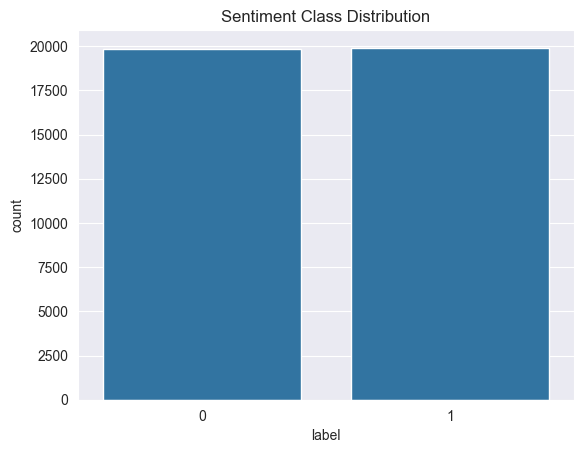

In [38]:
sns.countplot(x='label',data=df)
plt.title("Sentiment Class Distribution")
plt.show()

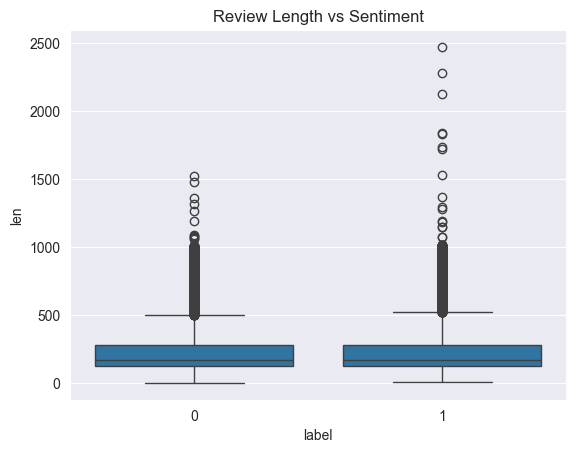

In [39]:
df['len'] = df['text'].apply(lambda x: len(x.split()))
sns.boxplot(x='label', y='len', data=df)
plt.title("Review Length vs Sentiment")
plt.show()

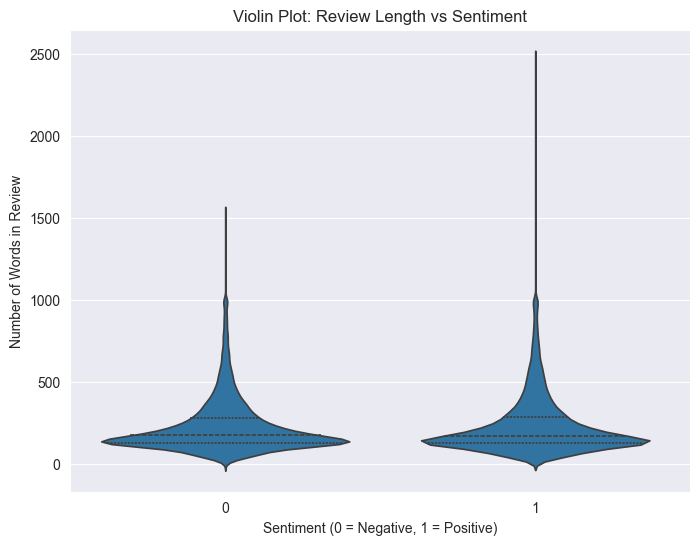

In [40]:
plt.figure(figsize=(8,6))
sns.violinplot(x='label', y='len', data=df, inner='quartile')
plt.title('Violin Plot: Review Length vs Sentiment')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Number of Words in Review')
plt.show()

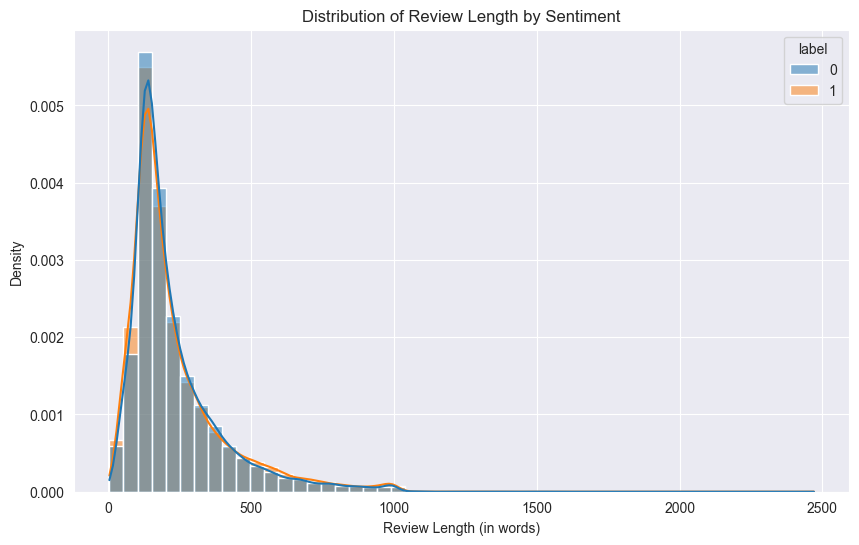

In [41]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='len', hue='label', bins=50, kde=True, stat='density', common_norm=False)
plt.title('Distribution of Review Length by Sentiment')
plt.xlabel('Review Length (in words)')
plt.ylabel('Density')
plt.show()

In [42]:
# 1. Lowercase the text
df['text'] = df['text'].str.lower()

# 2. Remove HTML tags
df['text'] = df['text'].apply(lambda x: re.sub(r'<.*?>', '', x))

# 3. Remove special characters, digits, punctuation, emojis
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# 4. Remove extra spaces
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [43]:
df.head()

,text,label,len
0,i grew up b watching and loving the thunderbir...,0,151
1,when i put this movie in my dvd player and sat...,0,326
2,why do people who do not know what a particula...,0,184
3,even though i have great interest in biblical ...,0,69
4,im a die hard dads army fan and nothing will e...,1,178


In [44]:
df['tokenized']=df['text'].apply(word_tokenize)

In [18]:
df.head()

,text,label,len,tokenized
0,i grew up b watching and loving the thunderbir...,0,151,"[i, grew, up, b, watching, and, loving, the, t..."
1,when i put this movie in my dvd player and sat...,0,326,"[when, i, put, this, movie, in, my, dvd, playe..."
2,why do people who do not know what a particula...,0,184,"[why, do, people, who, do, not, know, what, a,..."
3,even though i have great interest in biblical ...,0,69,"[even, though, i, have, great, interest, in, b..."
4,im a die hard dads army fan and nothing will e...,1,178,"[im, a, die, hard, dads, army, fan, and, nothi..."


In [49]:
stemmer = PorterStemmer()
df['stemmed'] = df['tokenized'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

In [45]:
df.head()


,text,label,len,tokenized
0,i grew up b watching and loving the thunderbir...,0,151,"[i, grew, up, b, watching, and, loving, the, t..."
1,when i put this movie in my dvd player and sat...,0,326,"[when, i, put, this, movie, in, my, dvd, playe..."
2,why do people who do not know what a particula...,0,184,"[why, do, people, who, do, not, know, what, a,..."
3,even though i have great interest in biblical ...,0,69,"[even, though, i, have, great, interest, in, b..."
4,im a die hard dads army fan and nothing will e...,1,178,"[im, a, die, hard, dads, army, fan, and, nothi..."


In [50]:
def evaluate_model(model, X_test, y_test):
    # Predict class labels
    y_pred = model.predict(X_test)
    y_pred=y_pred>0.5
    # For ROC-AUC, need prediction probabilities or decision function scores
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
        # Scale decision_function output to 0-1 for roc_auc_score if needed
        y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
    else:
        # fallback: use predicted labels for ROC-AUC (less ideal)
        y_scores = y_pred

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"Accuracy Score: {acc:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [51]:
df['clean_text'] = df['stemmed'].apply(lambda x: ' '.join(x))
X=df['clean_text']
y=df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# BoW
from sklearn.feature_extraction.text import CountVectorizer
# Step 1 & 2: Vectorize text into BoW
vectorizer = CountVectorizer()
X_train_enc = vectorizer.fit_transform(X_train)  # Fit & transform on train data
X_test_enc = vectorizer.transform(X_test)        # Transform on test data


In [53]:
# Logistic regression
log = LogisticRegression()
log.fit(X_train_enc, y_train)

evaluate_model(log, X_test_enc, y_test)

Accuracy Score: 0.8755
ROC-AUC Score: 0.9412
F1 Score: 0.8760
Confusion Matrix:
[[3462  529]
 [ 460 3494]]


/Users/dmitt/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
# SVM
svc=LinearSVC()
svc.fit(X_train_enc, y_train)
evaluate_model(svc, X_test_enc, y_test)

Accuracy Score: 0.8551
ROC-AUC Score: 0.9243
F1 Score: 0.8559
Confusion Matrix:
[[3377  614]
 [ 537 3417]]


/Users/dmitt/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [55]:
# Random forest
rnd_forest=RandomForestClassifier(n_estimators=100,random_state=42)
rnd_forest.fit(X_train_enc, y_train)
evaluate_model(rnd_forest, X_test_enc, y_test)

Accuracy Score: 0.8422
ROC-AUC Score: 0.9208
F1 Score: 0.8427
Confusion Matrix:
[[3333  658]
 [ 596 3358]]


In [56]:
# Naive Bayes
bern=BernoulliNB()
bern.fit(X_train_enc, y_train)
evaluate_model(bern, X_test_enc, y_test)

Accuracy Score: 0.8476
ROC-AUC Score: 0.9200
F1 Score: 0.8441
Confusion Matrix:
[[3456  535]
 [ 676 3278]]


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Convert sparse matrix to dense (only for BoW or TF-IDF)
X_train_enc = X_train_enc.toarray() if not isinstance(X_train_enc, np.ndarray) else X_train_enc
X_test_enc = X_test_enc.toarray() if not isinstance(X_test_enc, np.ndarray) else X_test_enc

# Define ANN model
ann = Sequential([
    Dense(64, input_dim=X_train_enc.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile
ann.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Train
ann.fit(X_train_enc, y_train, epochs=10, batch_size=32, verbose=1)

evaluate_model(ann, X_test_enc, y_test)

/Users/dmitt/PyCharmMiscProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
# OneHotEncoding
from sklearn.feature_extraction.text import CountVectorizer
# Step 1 & 2: Vectorize text into BoW
vectorizer = CountVectorizer(binary=True)
X_train_enc = vectorizer.fit_transform(X_train)  # Fit & transform on train data
X_test_enc = vectorizer.transform(X_test)        # Transform on test data

In [58]:
# Logistic regression
log = LogisticRegression()
log.fit(X_train_enc, y_train)

evaluate_model(log, X_test_enc, y_test)

Accuracy Score: 0.8692
ROC-AUC Score: 0.9407
F1 Score: 0.8695
Confusion Matrix:
[[3444  547]
 [ 492 3462]]


/Users/dmitt/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
# SVM
svc=LinearSVC()
svc.fit(X_train_enc, y_train)
evaluate_model(svc, X_test_enc, y_test)

Accuracy Score: 0.8540
ROC-AUC Score: 0.9252
F1 Score: 0.8541
Confusion Matrix:
[[3389  602]
 [ 558 3396]]


In [60]:
# Random forest
rnd_forest=RandomForestClassifier(n_estimators=100,random_state=42)
rnd_forest.fit(X_train_enc, y_train)
evaluate_model(rnd_forest, X_test_enc, y_test)

Accuracy Score: 0.8467
ROC-AUC Score: 0.9230
F1 Score: 0.8465
Confusion Matrix:
[[3368  623]
 [ 595 3359]]


In [61]:
# Naive Bayes
bern=BernoulliNB()
bern.fit(X_train_enc, y_train)
evaluate_model(bern, X_test_enc, y_test)

Accuracy Score: 0.8476
ROC-AUC Score: 0.9200
F1 Score: 0.8441
Confusion Matrix:
[[3456  535]
 [ 676 3278]]


In [ ]:
# ANN
X_train_enc=X_train_enc.toarray()
X_test_enc=X_test_enc.toarray()
ann = Sequential([
    Dense(5, input_dim=X_train_enc.shape[1], activation='relu'),
    Dense(5,  activation='relu'),
    Dense(1, activation='sigmoid')  # for binary classification
])

# Step 4: Compile the model
ann.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train
ann.fit(X_train_enc, y_train, epochs=10, batch_size=2, verbose=1)
evaluate_model(ann, X_test_enc, y_test)

In [62]:
# TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_enc = vectorizer.fit_transform(X_train)  # Fit on training data
X_test_enc = vectorizer.transform(X_test)        # Transform test data

In [63]:
# Logistic regression
log = LogisticRegression()
log.fit(X_train_enc, y_train)

evaluate_model(log, X_test_enc, y_test)

Accuracy Score: 0.8868
ROC-AUC Score: 0.9550
F1 Score: 0.8881
Confusion Matrix:
[[3480  511]
 [ 388 3566]]


In [64]:
# SVM
svc=LinearSVC()
svc.fit(X_train_enc, y_train)
evaluate_model(svc, X_test_enc, y_test)

Accuracy Score: 0.8875
ROC-AUC Score: 0.9561
F1 Score: 0.8882
Confusion Matrix:
[[3498  493]
 [ 401 3553]]


In [65]:
# Random forest
rnd_forest=RandomForestClassifier(n_estimators=100,random_state=42)
rnd_forest.fit(X_train_enc, y_train)
evaluate_model(rnd_forest, X_test_enc, y_test)

Accuracy Score: 0.8331
ROC-AUC Score: 0.9127
F1 Score: 0.8320
Confusion Matrix:
[[3336  655]
 [ 671 3283]]


In [66]:
# Naive Bayes
bern=BernoulliNB()
bern.fit(X_train_enc, y_train)
evaluate_model(bern, X_test_enc, y_test)

Accuracy Score: 0.8476
ROC-AUC Score: 0.9200
F1 Score: 0.8441
Confusion Matrix:
[[3456  535]
 [ 676 3278]]


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Convert sparse matrix to dense (only for BoW or TF-IDF)
X_train_enc = X_train_enc.toarray() if not isinstance(X_train_enc, np.ndarray) else X_train_enc
X_test_enc = X_test_enc.toarray() if not isinstance(X_test_enc, np.ndarray) else X_test_enc

# Define ANN model
ann = Sequential([
    Dense(64, input_dim=X_train_enc.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile
ann.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Train
ann.fit(X_train_enc, y_train, epochs=10, batch_size=32, verbose=1)

evaluate_model(ann, X_test_enc, y_test)

In [67]:
# Word2Vec
import numpy as np
from gensim.models import Word2Vec

# Tokenize your documents into words
X_train_tok = [doc.split() for doc in X_train]
X_test_tok = [doc.split() for doc in X_test]

# Train Word2Vec on training tokens
model = Word2Vec(sentences=X_train_tok, vector_size=100, window=5, min_count=1, workers=4)

# Function to get average Word2Vec embedding for a document
def get_avg_vector(doc, model, vector_size):
    vecs = [model.wv[word] for word in doc if word in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(vector_size)

# Convert documents to vectors
X_train_enc = np.array([get_avg_vector(doc, model, 100) for doc in X_train_tok])
X_test_enc = np.array([get_avg_vector(doc, model, 100) for doc in X_test_tok])

In [68]:
# Logistic regression
log = LogisticRegression()
log.fit(X_train_enc, y_train)

evaluate_model(log, X_test_enc, y_test)

Accuracy Score: 0.8378
ROC-AUC Score: 0.9159
F1 Score: 0.8385
Confusion Matrix:
[[3311  680]
 [ 609 3345]]


In [69]:
# SVM
svc=LinearSVC()
svc.fit(X_train_enc, y_train)
evaluate_model(svc, X_test_enc, y_test)

Accuracy Score: 0.8376
ROC-AUC Score: 0.9159
F1 Score: 0.8385
Confusion Matrix:
[[3305  686]
 [ 604 3350]]


In [70]:
# Random forest
rnd_forest=RandomForestClassifier(n_estimators=100,random_state=42)
rnd_forest.fit(X_train_enc, y_train)
evaluate_model(rnd_forest, X_test_enc, y_test)

Accuracy Score: 0.7992
ROC-AUC Score: 0.8796
F1 Score: 0.8031
Confusion Matrix:
[[3098  893]
 [ 702 3252]]


In [71]:
# Naive Bayes
bern=BernoulliNB()
bern.fit(X_train_enc, y_train)
evaluate_model(bern, X_test_enc, y_test)

Accuracy Score: 0.6876
ROC-AUC Score: 0.7572
F1 Score: 0.6741
Confusion Matrix:
[[2896 1095]
 [1387 2567]]


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Convert sparse matrix to dense (only for BoW or TF-IDF)
X_train_enc = X_train_enc.toarray() if not isinstance(X_train_enc, np.ndarray) else X_train_enc
X_test_enc = X_test_enc.toarray() if not isinstance(X_test_enc, np.ndarray) else X_test_enc

# Define ANN model
ann = Sequential([
    Dense(64, input_dim=X_train_enc.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile
ann.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Train
ann.fit(X_train_enc, y_train, epochs=10, batch_size=32, verbose=1)

evaluate_model(ann, X_test_enc, y_test)

AttributeError: module 'numpy' has no attribute 'dtypes'